In [1]:
import sys

if "../src" not in sys.path:
    sys.path.insert(0, "../src")

In [2]:
import os
import json
import copy
import pprint
import ast
import re
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display

import torch

from utils import read_json_file

In [3]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     /cephyr/users/mehrdadf/Alvis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
from experiments.utils import load_atlas
from experiments.tools import predict_token

/mimer/NOBACKUP/groups/snic2022-22-1003/APP/rag-memory-interplay/venv/lib/python3.9/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [5]:
os.environ["WANDB_CACHE_DIR"] = f"../../caches/wandb"
os.environ["TRANSFORMERS_CACHE"]= f"../../.cache/huggingface/transformers"
os.environ["HF_DATASETS_CACHE"] = f"../../.cache/huggingface/datasets"

SIZE = "base"  # "base", "large"
QA_PROMPT_FORMAT = "question: {question} answer: <extra_id_0>"

reader_model_type = f"google/t5-{SIZE}-lm-adapt"
model_path = f"../data/atlas/models/atlas_nq/{SIZE}"
model, opt = load_atlas(reader_model_type, model_path, n_context=1, qa_prompt_format="question: {question} answer: <extra_id_0>")
type(model)


/mimer/NOBACKUP/groups/snic2022-22-1003/APP/rag-memory-interplay/venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the model checkpoint at facebook/contriever were not used when initializing Contriever: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing Contriever from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Contriever from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification

atlas.atlas.Atlas

In [6]:
context_templates = {
    "occupation": "The occupation of {subj} is {obj}.",
    "place of birth": "{subj} was born in the city of {obj}.",
    "genre": "The work titled {subj} belongs to the {obj} genre.",
    "father": "{obj} is the father of {subj}.",
    "country": "The {subj} is located in {obj}.",
    "producer": "{obj} was the producer of the work {subj}.",
    "director": "{obj} was the director of the film {subj}.",
    "capital of": "{subj} is the capital of {obj}.",
    "capital": "The capital of {subj} is {obj}.",
    "screenwriter": "{obj} was the screenwriter for the film {subj}.",
    "composer": "{obj} was the composer of the musical work {subj}.",
    "color": "The color of {subj} is {obj}.",
    "religion": "{subj} practices the {obj} religion.",
    "sport": "The {subj} team plays the sport of {obj}.",
    "author": "{obj} is the author of the book titled {subj}.",
    "mother": "{obj} is the mother of {subj}.",
}


In [7]:
data = []

for row in read_json_file("../data/atlas/popqa_data/test.jsonl", jsonl=True):
    data.append({
        "question": row["question"],
        "answers": [row["triplet"]["obj"]],
        "query": f"question: {row['question']} answer: <extra_id_0>",
        "subj": row["triplet"]["subj"],
        "prop": row["triplet"]["prop"],
        "obj": row["triplet"]["obj"],
        "views": row["views"],
        "metadata": [],
        "passages": [{"title": "", "text": context_templates.get(row["triplet"]["prop"], "").format(subj=row["triplet"]["subj"], obj=row["triplet"]["obj"])}] 
        if context_templates.get(row["triplet"]["prop"], None) else None
    })

    # break

df = pd.DataFrame(data)
print(f"We have #{len(df)} data")
df = df.dropna()
df = df.drop_duplicates(subset=["query", "subj", "obj"], keep="first").reset_index(drop=True)
print(f"We have #{len(df)} data")
df.head(2)

We have #14267 data
We have #14221 data


,question,answers,query,subj,prop,obj,views,metadata,passages
0,What is George Rankin's occupation?,[politician],question: What is George Rankin's occupation? ...,George Rankin,occupation,politician,"{'s_pop': '142', 'o_pop': '25692'}",[],"[{'title': '', 'text': 'The occupation of Geor..."
1,What is John Mayne's occupation?,[journalist],question: What is John Mayne's occupation? ans...,John Mayne,occupation,journalist,"{'s_pop': '236', 'o_pop': '24952'}",[],"[{'title': '', 'text': 'The occupation of John..."


In [8]:
for prop in df["prop"].unique():
    print(prop, ":", df[df["prop"] == prop].iloc[1]["question"])

occupation : What is John Mayne's occupation?
place of birth : In what city was Antoine Richard born?
genre : What genre is Full Force?
father : Who is the father of Nero?
country : In what country is Snapchat?
producer : Who was the producer of Maari?
director : Who was the director of Another Country?
capital of : What is Howard the capital of?
screenwriter : Who was the screenwriter for The Circus?
composer : Who was the composer of Mexico?
color : What color is AFC Bournemouth?
religion : What is the religion of Kenneth Steiner?
sport : What sport does Armand Raymond play?
author : Who is the author of All Over?
mother : Who is the mother of Horae?
capital : What is the capital of Czechoslovakia?


In [9]:
subj_df = pd.DataFrame([{"subj": row["subj"], "prop": row["prop"], "tokens": model.reader_tokenizer.tokenize(row["subj"]), "len": len(model.reader_tokenizer.tokenize(row["subj"]))} for i, row in df.iterrows()])
subj_df = subj_df.drop_duplicates(subset=["subj", "prop"])
subj_df = subj_df.reset_index(drop=True)
subj_df.head()

,subj,prop,tokens,len
0,George Rankin,occupation,"[▁George, ▁, Rank, in]",4
1,John Mayne,occupation,"[▁John, ▁May, n, e]",4
2,Henry Feilden,occupation,"[▁Henry, ▁Fe, il, den]",4
3,Kathy Saltzman,occupation,"[▁Kathy, ▁Salt, z, man]",4
4,Eleanor Davis,occupation,"[▁Ele, an, or, ▁Davis]",4


In [10]:
obj_df = pd.DataFrame([{"obj": row["obj"], "prop": row["prop"], "tokens": model.reader_tokenizer.tokenize(row["obj"]), "len": len(model.reader_tokenizer.tokenize(row["obj"]))} for i, row in df.iterrows()])
obj_df = obj_df.drop_duplicates(subset=["obj", "prop"])
obj_df = obj_df.reset_index(drop=True)
obj_df.head()

,obj,prop,tokens,len
0,politician,occupation,[▁politician],1
1,journalist,occupation,[▁journalist],1
2,cartoonist,occupation,"[▁cartoon, ist]",2
3,mathematician,occupation,"[▁math, e, m, a, tician]",5
4,talent manager,occupation,"[▁talent, ▁manager]",2


In [11]:
prop_df = pd.DataFrame([{"prop": row["prop"], "tokens": model.reader_tokenizer.tokenize(row["prop"]), "len": len(model.reader_tokenizer.tokenize(row["prop"]))} for i, row in df.iterrows()])
prop_df = prop_df.drop_duplicates(subset=["prop"])
prop_df = prop_df.reset_index(drop=True)
prop_df.head()

,prop,tokens,len
0,occupation,[▁occupation],1
1,place of birth,"[▁place, ▁of, ▁birth]",3
2,genre,[▁genre],1
3,father,[▁father],1
4,country,[▁country],1


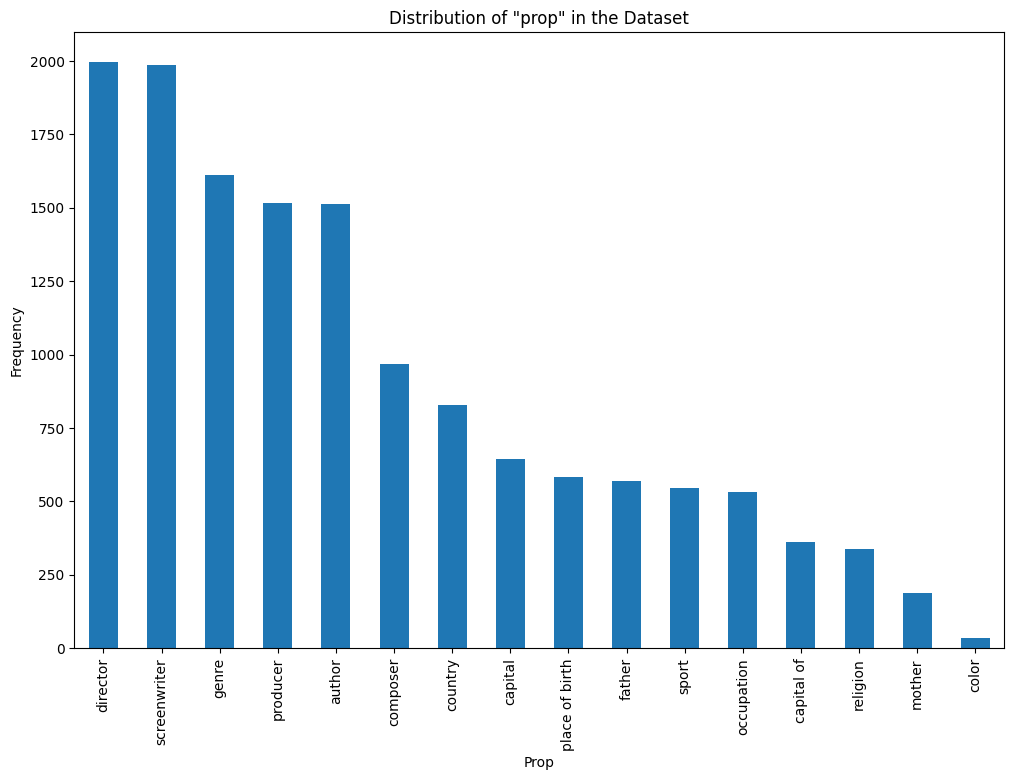

In [12]:
prop_counts = df['prop'].value_counts()
plt.figure(figsize=(12, 8)) 
prop_counts.plot(kind='bar')
plt.title('Distribution of "prop" in the Dataset')
plt.xlabel('Prop')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotates the x-axis labels for better readability
plt.show()

In [13]:
prop_counts.sum()

14221

In [14]:
df.iloc[1].to_dict()

{'question': "What is John Mayne's occupation?",
 'answers': ['journalist'],
 'query': "question: What is John Mayne's occupation? answer: <extra_id_0>",
 'subj': 'John Mayne',
 'prop': 'occupation',
 'obj': 'journalist',
 'views': {'s_pop': '236', 'o_pop': '24952'},
 'metadata': [],
 'passages': [{'title': '',
   'text': 'The occupation of John Mayne is journalist.'}]}

In [15]:
def filter_attribute_same_domain(df, row, model, attribute="subj", k=10, random_state=101):
    """Filters attribute based on specific criteria."""
    # Combine conditions to filter df in one step
    conditions = (
        (df[attribute] != row[attribute]) &
        (df["prop"] == row["prop"]) &
        (df["len"].apply(lambda x: x == len(model.reader_tokenizer.tokenize(row[attribute]))))
    )

    filtered_df = df[conditions]

    if not filtered_df.empty:
        sampled_df = filtered_df.sample(n=min(k, len(filtered_df)), random_state=random_state)
        return sampled_df[attribute].tolist()
    else:
        return []

def filter_attribute_diff_domain(df, row, model, attribute="subj", k=10, random_state=101):
    """Filters attribute based on specific criteria."""
    # Combine conditions to filter df in one step
    conditions = (
        (df[attribute] != row[attribute]) &
        (df["prop"] != row["prop"]) &
        (df["len"].apply(lambda x: x == len(model.reader_tokenizer.tokenize(row[attribute]))))
    )

    filtered_df = df[conditions]

    if not filtered_df.empty:
        sampled_df = filtered_df.sample(n=min(k, len(filtered_df)), random_state=random_state)
        return sampled_df[attribute].tolist()
    else:
        return []

In [17]:
def generated_is_matched(answer, generated):
    return generated and (answer == generated or generated in answer or answer in generated)


def batchify(lst, batch_size):
    for i in range(0, len(lst), batch_size):
        yield lst[i:i + batch_size]


def attribute_status(text, attr1, attr2):
    status = [False, False]
    if attr1 in text:
        _text = copy.deepcopy(text)
        _text = re.sub(fr'\b{re.escape(attr1)}\b', f"[{attr1.upper()}_REPLACED]", _text)
        
        status[0] = True
        if attr2 in _text:
            status[1] = True
        else:
            status[1] = False
    else:
        status = [False, False]

    return all(status)

def pick_the_candidates(df, batch_size=5):
    data = []
    for i, row in tqdm(df.iterrows(), total=len(df)):
        query = row["query"]
        answers = row["answers"]

        question = row["question"]
        subj = row["subj"]
        prop = row["prop"]
        obj = row["obj"]
        views = row["views"]


        subj_cf_same_domain = filter_attribute_same_domain(subj_df, row, model, attribute="subj")
        obj_cf_same_domain = filter_attribute_same_domain(obj_df, row, model, attribute="obj")

        subj_cf_diff_domain = filter_attribute_diff_domain(subj_df, row, model, attribute="subj")
        obj_cf_diff_domain = filter_attribute_diff_domain(obj_df, row, model, attribute="obj")

        if not len(subj_cf_same_domain) > 1 or not len(obj_cf_same_domain) > 1:
            continue


        p = row["passages"][0]
        subj_status = attribute_status(p["text"], subj, obj)
        obj_status = attribute_status(p["text"], obj, subj)

        if not subj_status or not obj_status:
            continue

        prompts_nocontext = [{"query": query, "passages": [{"title": "", "text": ""}], "answers": answers}]
        prompt_split = len(prompts_nocontext)
        prompts_context = [{"query": query, "passages": [{"title": " ", "text": p["text"]}], "answers": answers}]

        g = predict_token(model, prompts_nocontext + prompts_context, n_context=1).predicted_text
        for i in range(prompt_split):
            gen_nocontext_matched = generated_is_matched(answers[0], g[i])
            gen_context_matched = generated_is_matched(answers[0], g[i + prompt_split])

            data.append({
                "question": question,
                "answers": answers,
                "passages": [p],
                "subj": subj,
                "prop": prop,
                "obj": obj,
                "views": views,
                "query": query,
                "gen_nocontext": g[i],
                "gen_context": g[i + prompt_split],
                "gen_nocontext_matched": gen_nocontext_matched,
                "gen_context_matched": gen_context_matched,
                "matched": gen_nocontext_matched and gen_context_matched,
                # "prop_cf": [context_templates[cf].format(subj=subj, obj=obj) for cf in relation_counterfactuals[prop]],
                "prop_cf": [],
                "subj_cf": subj_cf_same_domain,
                "obj_cf": obj_cf_same_domain,
                "subj_cf_diff": subj_cf_diff_domain,
                "obj_cf_diff": obj_cf_diff_domain,
            })
            
            break

        break
    
    return pd.DataFrame(data)

In [18]:
print(f"Number of data: {len(df)}")
matched_df = pick_the_candidates(df)
print(f"Number of data: {len(matched_df)}")
matched_df.head()

Number of data: 14221


  0%|          | 0/14221 [00:00<?, ?it/s]/mimer/NOBACKUP/groups/snic2022-22-1003/APP/rag-memory-interplay/venv/lib/python3.9/site-packages/transformers/modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/mimer/NOBACKUP/groups/snic2022-22-1003/APP/rag-memory-interplay/venv/lib/python3.9/site-packages/transformers/modeling_utils.py:1080: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  0%|          | 0/14221 [00:02<?, ?it/s]

Number of data: 1


,question,answers,passages,subj,prop,obj,views,query,gen_nocontext,gen_context,gen_nocontext_matched,gen_context_matched,matched,prop_cf,subj_cf,obj_cf,subj_cf_diff,obj_cf_diff
0,What is George Rankin's occupation?,[politician],"[{'title': '', 'text': 'The occupation of Geor...",George Rankin,occupation,politician,"{'s_pop': '142', 'o_pop': '25692'}",question: What is George Rankin's occupation? ...,a lawyer,politician,False,True,False,[],"[Meg McCall, Nathan Purdee, Guy Joseph Bonnet,...","[illustrator, model, musician, psychiatrist, l...","[Mary of Woodstock, Bad News Bears, Rakhyah Di...","[Madrid, Lisbon, Armenia, Slovakia, Columbia, ..."


In [19]:
def save_data(df, save_dir, kind, groupby="prop"):
    save_dir = f"{save_dir}-{kind}"
    os.makedirs(save_dir, exist_ok=True)
    with open(f"{save_dir}-data.jsonl", "w", encoding="utf-8") as fj:
        for index, row in df.iterrows():
            fj.write(json.dumps(row.to_dict()) + "\n")

    props = df[groupby].unique()
    for prop in props:
        prop_code = prop.replace(" ", '_')
        prop_df = df[df[groupby] == prop]

        with open(f"{save_dir}/{prop_code}.jsonl", "w", encoding="utf-8") as fj:
            for index, row in prop_df.iterrows():
                fj.write(json.dumps(row.to_dict()) + "\n")

In [20]:
SAVE_DIR = "../data/syn/popqa/data/matched"
SAVE_DIR

'../data/syn/popqa/data/matched'

In [21]:
save_data(matched_df, SAVE_DIR, "all")


df_both = matched_df[matched_df["matched"] == True]
print(f"Collected {len(df_both)}/{len(matched_df)}")
save_data(df_both, SAVE_DIR, "both")

df_both_first = matched_df[matched_df["matched"] == True].groupby('question').first().reset_index()
print(f"Collected {len(df_both_first)}/{len(matched_df)}")
save_data(df_both_first, SAVE_DIR, "both-first")

df_gen_nocontext = matched_df[matched_df["gen_nocontext_matched"] == True]
print(f"Collected {len(df_gen_nocontext)}/{len(matched_df)}")
save_data(df_gen_nocontext, SAVE_DIR, "gen-nocontext")

df_gen_context = matched_df[matched_df["gen_context_matched"] == True]
print(f"Collected {len(df_gen_context)}/{len(matched_df)}")
save_data(df_gen_context, SAVE_DIR, "gen-context")

Collected 0/1
Collected 0/1
Collected 0/1
Collected 1/1
